In [76]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import copy 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
import seaborn as sns

### Part 1: Read in the data

In [2]:
path= '/Users/philhuang/Desktop/Phil_projects/P5_PhilHuang/workingdata/'

file_2020q1_OH=pd.read_csv(path+'file_2020Q1_OH.csv')
file_2020q1_VA=pd.read_csv(path+'file_2020Q1_VA.csv')
file_2020q1_GA=pd.read_csv(path+'file_2020Q1_GA.csv')
file_2020q1_MI=pd.read_csv(path+'file_2020Q1_MI.csv')
file_2020q1_CO=pd.read_csv(path+'file_2020Q1_CO.csv')

In [3]:
# Concat the data files together.
df = pd.concat([file_2020q1_OH, file_2020q1_VA, file_2020q1_GA, file_2020q1_MI, file_2020q1_CO])
df.shape

(2071611, 108)

In [4]:
# See how many unique loans there are.
df['LOAN_ID'].nunique()

104924

In [5]:
# Look at the loans by state.
df.groupby('STATE')['LOAN_ID'].count()

STATE
CO    485045
GA    428255
MI    479014
OH    339552
VA    339745
Name: LOAN_ID, dtype: int64

### Part 2: Define 'bad' loan.
* We intend to apply a more stringent criterion for defining 'bad'.
* This definition bad will be used to build a payment default model.
* Two things to consider for defining such a variable as 'bad':
** The definition should be representative of bad/derogatory behavior
** We can get enough such data points for modeling

In [6]:
# Take out all the features we have.
df.columns.tolist()

['POOL_ID',
 'LOAN_ID',
 'ACT_PERIOD',
 'CHANNEL',
 'SELLER',
 'SERVICER',
 'MASTER_SERVICER',
 'ORIG_RATE',
 'CURR_RATE',
 'ORIG_UPB',
 'ISSUANCE_UPB',
 'CURRENT_UPB',
 'ORIG_TERM',
 'ORIG_DATE',
 'FIRST_PAY',
 'LOAN_AGE',
 'REM_MONTHS',
 'ADJ_REM_MONTHS',
 'MATR_DT',
 'OLTV',
 'OCLTV',
 'NUM_BO',
 'DTI',
 'CSCORE_B',
 'CSCORE_C',
 'FIRST_FLAG',
 'PURPOSE',
 'PROP',
 'NO_UNITS',
 'OCC_STAT',
 'STATE',
 'MSA',
 'ZIP',
 'MI_PCT',
 'PRODUCT',
 'PPMT_FLG',
 'IO',
 'FIRST_PAY_IO',
 'MNTHS_TO_AMTZ_IO',
 'DLQ_STATUS',
 'PMT_HISTORY',
 'MOD_FLAG',
 'MI_CANCEL_FLAG',
 'Zero_Bal_Code',
 'ZB_DTE',
 'LAST_UPB',
 'RPRCH_DTE',
 'CURR_SCHD_PRNCPL',
 'TOT_SCHD_PRNCPL',
 'UNSCHD_PRNCPL_CURR',
 'LAST_PAID_INSTALLMENT_DATE',
 'FORECLOSURE_DATE',
 'DISPOSITION_DATE',
 'FORECLOSURE_COSTS',
 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS',
 'ASSET_RECOVERY_COSTS',
 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
 'NET_SALES_PROCEEDS',
 'CREDIT_ENHANCEMENT_PROCEEDS',
 'REPUR

In [7]:
# Look at the delinquency.
df.groupby('DLQ_STATUS')['LOAN_ID'].count()

DLQ_STATUS
0     2019379
1       14783
2        7204
3        5353
4        3983
5        3351
6        2724
7        2209
8        1934
9        1704
10       1510
11       1368
12       1146
13        963
14        856
15        746
16        617
17        557
18        409
19        296
20        250
21        145
22         70
23         40
24         14
Name: LOAN_ID, dtype: int64

In [8]:
# Define bad loans when there is over six months' delinquency.
df['bad']=np.where(df['DLQ_STATUS'] >= 6, 1, 0)

# Take the bad loans out. As long as there is one bucket six, we define the whole loan as a bad loan.
df_bad=df.groupby('LOAN_ID')['bad'].sum().reset_index()
df_bad['bad']=np.where(df_bad['bad'] > 0, 1, 0)

In [9]:
# Look at the statistics.
print(df_bad['bad'].mean())
print(df_bad['bad'].sum())

0.02353131790629408
2469


In [10]:
df_bad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104924 entries, 0 to 104923
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   LOAN_ID  104924 non-null  int64
 1   bad      104924 non-null  int64
dtypes: int64(2)
memory usage: 1.6 MB


In [11]:
# Create a dataset with unique loan IDs.
df_nodup = df.drop_duplicates(subset='LOAN_ID', keep='first').reset_index()
df_nodup.columns.tolist()

['index',
 'POOL_ID',
 'LOAN_ID',
 'ACT_PERIOD',
 'CHANNEL',
 'SELLER',
 'SERVICER',
 'MASTER_SERVICER',
 'ORIG_RATE',
 'CURR_RATE',
 'ORIG_UPB',
 'ISSUANCE_UPB',
 'CURRENT_UPB',
 'ORIG_TERM',
 'ORIG_DATE',
 'FIRST_PAY',
 'LOAN_AGE',
 'REM_MONTHS',
 'ADJ_REM_MONTHS',
 'MATR_DT',
 'OLTV',
 'OCLTV',
 'NUM_BO',
 'DTI',
 'CSCORE_B',
 'CSCORE_C',
 'FIRST_FLAG',
 'PURPOSE',
 'PROP',
 'NO_UNITS',
 'OCC_STAT',
 'STATE',
 'MSA',
 'ZIP',
 'MI_PCT',
 'PRODUCT',
 'PPMT_FLG',
 'IO',
 'FIRST_PAY_IO',
 'MNTHS_TO_AMTZ_IO',
 'DLQ_STATUS',
 'PMT_HISTORY',
 'MOD_FLAG',
 'MI_CANCEL_FLAG',
 'Zero_Bal_Code',
 'ZB_DTE',
 'LAST_UPB',
 'RPRCH_DTE',
 'CURR_SCHD_PRNCPL',
 'TOT_SCHD_PRNCPL',
 'UNSCHD_PRNCPL_CURR',
 'LAST_PAID_INSTALLMENT_DATE',
 'FORECLOSURE_DATE',
 'DISPOSITION_DATE',
 'FORECLOSURE_COSTS',
 'PROPERTY_PRESERVATION_AND_REPAIR_COSTS',
 'ASSET_RECOVERY_COSTS',
 'MISCELLANEOUS_HOLDING_EXPENSES_AND_CREDITS',
 'ASSOCIATED_TAXES_FOR_HOLDING_PROPERTY',
 'NET_SALES_PROCEEDS',
 'CREDIT_ENHANCEMENT_PROCEEDS

#### merge the data 

In [12]:
# Now we merge the loan information with the 'bad' dummy.
df_nodup = pd.merge(df_nodup.drop('bad', axis=1), df_bad, on='LOAN_ID', how='inner')

In [13]:
# Check the data and see if the merge process is correct.
df_nodup['bad'].mean()

0.02353131790629408

### Part 3: Select variables for modeling
* Since this is an underwriting model, we will only select those variables available at the time of origination. 
* These varibles do not change their values throughout the life of a loan. 

In [14]:
# Define a function to construct dummy variables.
def dummyvar(x):
    
    # See if the purpose of the loan is 'Refinance'.
    x['purpose_rate_refi']=np.where(x['PURPOSE'].str.strip()=='R', 1, 0)
    
    # See if the purpose of the loan is 'Cssh-out Refinance'.
    x['purpose_cashout_refi']=np.where(x['PURPOSE'].str.strip()=='C', 1, 0)
    
    # See if the type of the property is 'Planned Urban Development'.
    x['property_pud']=np.where(x['PROP'].str.strip()=='PU', 1, 0)
    
    # See if the type of the property is 'condominium'.
    x['property_condo']=np.where(x['PROP'].str.strip()=='CO', 1, 0)
    
    # See if the type of the property is 'co-operative' or 'manufactured home'.
    x['property_other']=np.where(x['PROP'].str.strip().isin(['CP', 'MH']), 1, 0)
    
    # Dummies of the term of the loan.
    x['term_30years']=np.where(x['ORIG_TERM']==360, 1, 0)
    x['term_15years']=np.where(x['ORIG_TERM']==180, 1, 0)
    
    # Dummy of Mortgage Insurance Percentage.
    x['mi']=np.where(x['MI_PCT'] > 0, 1, 0)
    

In [15]:
# Construct dummies.
dummyvar(df_nodup)

In [16]:
# Keep some of the variables.
columns_to_keep=['CSCORE_B', 'DTI', 'OLTV', 'ORIG_UPB', 'bad', 'LOAN_ID']

df_nodup[columns_to_keep].describe().T

,count,mean,std,min,25%,50%,75%,max
CSCORE_B,104873.0,7.567624e+02,42.412137,620.0,729.00,766.0,791.00,835.0
DTI,104922.0,3.415779e+01,9.579630,1.0,27.00,35.0,42.00,50.0
OLTV,104924.0,7.392929e+01,16.254267,7.0,65.00,76.0,85.00,97.0
ORIG_UPB,104924.0,2.537213e+05,123826.341576,10000.0,156000.00,237000.0,335000.00,800000.0
bad,104924.0,2.353132e-02,0.151584,0.0,0.00,0.0,0.00,1.0
LOAN_ID,104924.0,9.917922e+07,197019.945107,98836742.0,99009455.75,99180553.5,99349026.75,99520476.0


In [17]:
# remove loans with no credit score or DTI
df_sample=df_nodup[(df_nodup['CSCORE_B'] > 0) & (df_nodup['DTI'] > 0)][columns_to_keep]
df_sample.describe().T

,count,mean,std,min,25%,50%,75%,max
CSCORE_B,104871.0,7.567624e+02,42.412282,620.0,729.0,766.0,791.0,835.0
DTI,104871.0,3.416106e+01,9.578838,1.0,27.0,35.0,42.0,50.0
OLTV,104871.0,7.392818e+01,16.254008,7.0,65.0,76.0,85.0,97.0
ORIG_UPB,104871.0,2.537530e+05,123823.523399,10000.0,156000.0,237000.0,335000.0,800000.0
bad,104871.0,2.354321e-02,0.151622,0.0,0.0,0.0,0.0,1.0
LOAN_ID,104871.0,9.917920e+07,197011.330265,98836742.0,99009454.5,99180544.0,99349004.0,99520476.0


### Part 4: Logistic Regression Model
* Split the sample into a modeling sample and a validation sample

In [18]:
# By defining the random seed first, we will have the same split for modeling sample and validation sample 
# when you rerun the program. 
# By doing so, we will have the same regression results everyone when we rerun the entire program.
np.random.seed(seed=3)
df_sample['random']=np.random.uniform(0, 1, len(df_sample['CSCORE_B']))

In [19]:
# make a copy of original variables
df_sample['CSCORE_B_raw'] = df_sample['CSCORE_B']
df_sample['DTI_raw']      = df_sample['DTI']
df_sample['OLTV_raw']     = df_sample['OLTV']
df_sample['ORIG_UPB_raw'] = df_sample['ORIG_UPB']

df_sample.head()

,CSCORE_B,DTI,OLTV,ORIG_UPB,bad,LOAN_ID,random,CSCORE_B_raw,DTI_raw,OLTV_raw,ORIG_UPB_raw
0,806.0,25.0,66,207000.0,0,98836743,0.550798,806.0,25.0,66,207000.0
1,745.0,42.0,73,215000.0,0,98836744,0.708148,745.0,42.0,73,215000.0
2,755.0,31.0,63,210000.0,1,98836805,0.290905,755.0,31.0,63,210000.0
3,739.0,36.0,97,200000.0,0,98836862,0.510828,739.0,36.0,97,200000.0
4,665.0,40.0,95,109000.0,0,98836951,0.892947,665.0,40.0,95,109000.0


In [20]:
# We have 60% of training sample and 40% validation sample.
df_sample['seg']=np.where(df_sample['random'] <= 0.6, 'mod', 'val')
df_mod = copy.deepcopy(df_sample[df_sample['seg']=='mod'])
df_val = copy.deepcopy(df_sample[df_sample['seg']=='val'])

print("Average bad rate for the modeling sample:", df_mod['bad'].mean())
print("Average bad rate for the validation sample:", df_val['bad'].mean())

Average bad rate for the modeling sample: 0.02409235135609165
Average bad rate for the validation sample: 0.022726194429947336


In [21]:
# Fit a logit model to the training set.
model = smf.logit('bad ~ CSCORE_B + DTI + OLTV + ORIG_UPB', data=df_mod).fit()

#view model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.104718
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    bad   No. Observations:                62717
Model:                          Logit   Df Residuals:                    62712
Method:                           MLE   Df Model:                            4
Date:                Sat, 12 Aug 2023   Pseudo R-squ.:                 0.07790
Time:                        15:40:42   Log-Likelihood:                -6567.6
converged:                       True   LL-Null:                       -7122.4
Covariance Type:            nonrobust   LLR p-value:                6.095e-239
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2938      0.477      4.813      0.000       1.360       3.228
CSCORE_B      -0.0134      0.

* Most regression will generate the above summary.
* We can use z score as an indicator for a variable's predictive value. 
* We cannot use the magnitude of coefficient estimator as the its predictive value. 
* There is a straightforward way to use coefficient estimator as an indicator for a variable's predictive power. 

In [22]:
# normalize all input variables so that they are all in the range [0, 1]
def normalize(x, sample):
    x_min  = df_mod[x].min()
    x_max  = df_mod[x].max()
    x_norm = (sample[x]-x_min)/(x_max-x_min)
    return x_norm

In [23]:
# normalization criteria (min, max, std) should be based on the modeling sample
df_mod['CSCORE_B'] = normalize('CSCORE_B_raw', df_mod)
df_mod['DTI']      = normalize('DTI_raw', df_mod)
df_mod['OLTV']     = normalize('OLTV_raw', df_mod)
df_mod['ORIG_UPB'] = normalize('ORIG_UPB_raw', df_mod)

In [24]:
# apply the same criteria on the validation sample.
# You cannot use the min and max based on the validation sample.
df_val['CSCORE_B'] = normalize('CSCORE_B_raw', df_val)
df_val['DTI']      = normalize('DTI_raw', df_val)
df_val['OLTV']     = normalize('OLTV_raw', df_val)
df_val['ORIG_UPB'] = normalize('ORIG_UPB_raw', df_val)

In [25]:
# check the transformation of all input variables
# check whether the sample has full coverge for all variables.  Missing values need to be imputed. 
# check whether max contains infinite values
# First the training set.
df_mod.drop(['LOAN_ID', 'random'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
CSCORE_B,62717.0,0.636291,0.197110,0.0,0.506977,0.679070,0.795349,1.0
DTI,62717.0,0.669452,0.199548,0.0,0.520833,0.687500,0.833333,1.0
OLTV,62717.0,0.743163,0.180119,0.0,0.644444,0.766667,0.866667,1.0
ORIG_UPB,62717.0,0.308445,0.156683,0.0,0.186076,0.287342,0.411392,1.0
bad,62717.0,0.024092,0.153337,0.0,0.000000,0.000000,0.000000,1.0
CSCORE_B_raw,62717.0,756.802510,42.378652,620.0,729.000000,766.000000,791.000000,835.0
DTI_raw,62717.0,34.133712,9.578324,2.0,27.000000,35.000000,42.000000,50.0
OLTV_raw,62717.0,73.884641,16.210735,7.0,65.000000,76.000000,85.000000,97.0
ORIG_UPB_raw,62717.0,253671.683913,123779.259828,10000.0,157000.000000,237000.000000,335000.000000,800000.0


In [26]:
# Then the validation set.
df_val.drop(['LOAN_ID', 'random'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
CSCORE_B,42154.0,0.635827,0.197501,0.000000,0.502326,0.679070,0.795349,0.986047
DTI,42154.0,0.670870,0.199574,-0.020833,0.520833,0.687500,0.833333,1.000000
OLTV,42154.0,0.744366,0.181313,0.011111,0.644444,0.766667,0.866667,1.000000
ORIG_UPB,42154.0,0.308701,0.156824,0.002532,0.184810,0.286076,0.412658,0.956962
bad,42154.0,0.022726,0.149031,0.000000,0.000000,0.000000,0.000000,1.000000
CSCORE_B_raw,42154.0,756.702828,42.462700,620.000000,728.000000,766.000000,791.000000,832.000000
DTI_raw,42154.0,34.201760,9.579572,1.000000,27.000000,35.000000,42.000000,50.000000
OLTV_raw,42154.0,73.992954,16.318154,8.000000,65.000000,76.000000,85.000000,97.000000
ORIG_UPB_raw,42154.0,253873.985861,123890.719446,12000.000000,156000.000000,236000.000000,336000.000000,766000.000000


* logistic regression

In [27]:
# Fit a logistic model.
model=smf.logit('bad ~ CSCORE_B + DTI + OLTV + ORIG_UPB', data=df_mod).fit()

#view model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.104718
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    bad   No. Observations:                62717
Model:                          Logit   Df Residuals:                    62712
Method:                           MLE   Df Model:                            4
Date:                Sat, 12 Aug 2023   Pseudo R-squ.:                 0.07790
Time:                        15:40:42   Log-Likelihood:                -6567.6
converged:                       True   LL-Null:                       -7122.4
Covariance Type:            nonrobust   LLR p-value:                6.095e-239
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7430      0.199    -28.862      0.000      -6.133      -5.353
CSCORE_B      -2.8829      0.

### Part 5: Model evaluation

In [28]:
# Note that the logistic function p(x) = exp(f(x))/(1+exp(f(x))) which simplifies to 
# p(x) = 1/(1+exp(-f(x))). We can then calculate the risk score:

def logit(x):
    x['risk_score']=-5.7430+-2.8829*x['CSCORE_B']+2.2651*x['DTI']+2.1547*x['OLTV']+1.1593*x['ORIG_UPB']
    x['risk_score']=1/(1+np.exp(-1*x['risk_score']))
    
logit(df_mod)
logit(df_val)

In [29]:
# divide the score into 10 evenly distributed bins
df_mod['risk_score_cut'] = pd.qcut(df_mod['risk_score'], 
                                   q=10, 
                                   retbins=False, 
                                   labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
# Look at the distribution of the risk scores.
dis_risk_score = pd.DataFrame(df_mod.groupby('risk_score_cut')[['risk_score', 'bad']].mean())
dis_risk_score.reset_index()

,risk_score_cut,risk_score,bad
0,0,0.003090,0.004464
1,1,0.005911,0.006059
2,2,0.008531,0.008771
3,3,0.011432,0.011798
4,4,0.014856,0.010842
5,5,0.019064,0.016744
6,6,0.024526,0.025829
7,7,0.032282,0.035082
8,8,0.044643,0.045918
9,9,0.076574,0.075415


In [37]:
# obtain the thresholds for dividing score into 10 bins
# The same thresholds should be applied to both modeling sample and validation sample
# Strictly speaking, you cannot create another score bins based on the validation sample 
# and then apply to the validation sample.
score_threshold = df_mod.groupby('risk_score_cut')['risk_score'].min().reset_index()
score_threshold

,risk_score_cut,risk_score
0,0,0.000394
1,1,0.004626
2,2,0.007218
3,3,0.009915
4,4,0.013043
5,5,0.016820
6,6,0.021546
7,7,0.027863
8,8,0.037333
9,9,0.053997


In [38]:
# Define a function to assign obervations to different bins for the validation group.
def score_cut(x):
    
    # Initially the risk score is ranked from lowest to highest.
    # For assigning score bins, we usually start with highest risk bin. 
    threshold0=score_threshold['risk_score'][9]
    threshold1=score_threshold['risk_score'][8]
    threshold2=score_threshold['risk_score'][7]
    threshold3=score_threshold['risk_score'][6]
    threshold4=score_threshold['risk_score'][5]
    threshold5=score_threshold['risk_score'][4]
    threshold6=score_threshold['risk_score'][3]
    threshold7=score_threshold['risk_score'][2]
    threshold8=score_threshold['risk_score'][1]
    
    if x > threshold0:
        return 1
    elif x > threshold1:
        return 2
    elif x > threshold2:
        return 3
    elif x > threshold3:
        return 4
    elif x > threshold4:
        return 5
    elif x > threshold5:
        return 6
    elif x > threshold6:
        return 7
    elif x > threshold7: 
        return 8
    elif x > threshold8:
        return 9
    else:
        return 10

In [39]:
# apply the same score cut to both modeling sample and validation sample
df_mod['risk_score_cut']=df_mod['risk_score'].apply(score_cut)
df_val['risk_score_cut']=df_val['risk_score'].apply(score_cut)

In [41]:
# check the performance of modeling sample
# We calculate the total loan count, mean predicted risk score, mean bad loan rate, and number of bad loans.
df_mod.groupby('risk_score_cut').agg(loan_cnt_mod=('CSCORE_B', 'count'),
                                     predicted_mod=('risk_score', 'mean'),
                                     actual_mod=('bad', 'mean'),
                                     bad_cnt_mod=('bad', 'sum')).reset_index()

,risk_score_cut,loan_cnt_mod,predicted_mod,actual_mod,bad_cnt_mod
0,1,6271,0.076578,0.075427,473
1,2,6272,0.044646,0.045918,288
2,3,6271,0.032283,0.035082,220
3,4,6272,0.024527,0.025829,162
4,5,6271,0.019065,0.016744,105
5,6,6272,0.014857,0.010842,68
6,7,6272,0.011432,0.011798,74
7,8,6271,0.008532,0.008771,55
8,9,6272,0.005912,0.006059,38
9,10,6273,0.003090,0.004464,28


In [43]:
# check the performance of validation sample
df_val.groupby('risk_score_cut').agg(loan_cnt_va=('CSCORE_B', 'count'),
                                     predicted_val=('risk_score', 'mean'),
                                     actual_val=('bad', 'mean'),
                                     bad_cnt_val=('bad', 'sum')).reset_index()

,risk_score_cut,loan_cnt_va,predicted_val,actual_val,bad_cnt_val
0,1,4357,0.077687,0.069543,303
1,2,4135,0.044741,0.045224,187
2,3,4242,0.032166,0.028760,122
3,4,4249,0.024508,0.020711,88
4,5,4149,0.019071,0.019282,80
5,6,4347,0.014861,0.013573,59
6,7,4202,0.011439,0.011661,49
7,8,4100,0.008542,0.008537,35
8,9,4198,0.005928,0.005241,22
9,10,4175,0.003050,0.003114,13


In [47]:
# summarize the data for graphing later
# training set
df_mod_agg=df_mod.groupby('risk_score_cut').agg(loan_cnt_mod=('CSCORE_B', 'count'),
                                                predicted_mod=('risk_score', 'mean'),
                                                actual_bad_mod=('bad', 'mean'),
                                                actual_bad_cnt_mod=('bad', 'sum'))

# Calculate how many 'good' loans there are. 
df_mod_agg['actual_good_cnt_mod']=df_mod_agg['loan_cnt_mod']-df_mod_agg['actual_bad_cnt_mod']

# Calculate the weight of each bin.
df_mod_agg['loan_pct_mod']=df_mod_agg['loan_cnt_mod']/len(df_mod['CSCORE_B'])

In [48]:
# Check the data.
df_mod_agg

,loan_cnt_mod,predicted_mod,actual_bad_mod,actual_bad_cnt_mod,actual_good_cnt_mod,loan_pct_mod
risk_score_cut,,,,,,
1,6271,0.076578,0.075427,473,5798,0.099989
2,6272,0.044646,0.045918,288,5984,0.100005
3,6271,0.032283,0.035082,220,6051,0.099989
4,6272,0.024527,0.025829,162,6110,0.100005
5,6271,0.019065,0.016744,105,6166,0.099989
6,6272,0.014857,0.010842,68,6204,0.100005
7,6272,0.011432,0.011798,74,6198,0.100005
8,6271,0.008532,0.008771,55,6216,0.099989
9,6272,0.005912,0.006059,38,6234,0.100005


In [49]:
# validation set
df_val_agg=df_val.groupby('risk_score_cut').agg(loan_cnt_val=('CSCORE_B', 'count'),
                                                predicted_val=('risk_score', 'mean'),
                                                actual_bad_val=('bad', 'mean'),
                                                actual_bad_cnt_val=('bad', 'sum'))

# Good loans.
df_val_agg['actual_good_cnt_val']=df_val_agg['loan_cnt_val']-df_val_agg['actual_bad_cnt_val']
df_val_agg['loan_pct_val']=df_val_agg['loan_cnt_val']/len(df_val['CSCORE_B'])

# Check the data.
df_val_agg

,loan_cnt_val,predicted_val,actual_bad_val,actual_bad_cnt_val,actual_good_cnt_val,loan_pct_val
risk_score_cut,,,,,,
1,4357,0.077687,0.069543,303,4054,0.103359
2,4135,0.044741,0.045224,187,3948,0.098093
3,4242,0.032166,0.028760,122,4120,0.100631
4,4249,0.024508,0.020711,88,4161,0.100797
5,4149,0.019071,0.019282,80,4069,0.098425
6,4347,0.014861,0.013573,59,4288,0.103122
7,4202,0.011439,0.011661,49,4153,0.099682
8,4100,0.008542,0.008537,35,4065,0.097262
9,4198,0.005928,0.005241,22,4176,0.099587


In [50]:
# Merge the summary statistics of the training and validation set together.
df_agg=pd.merge(df_mod_agg, df_val_agg, on='risk_score_cut', how='inner').reset_index()
df_agg

,risk_score_cut,loan_cnt_mod,predicted_mod,actual_bad_mod,actual_bad_cnt_mod,actual_good_cnt_mod,loan_pct_mod,loan_cnt_val,predicted_val,actual_bad_val,actual_bad_cnt_val,actual_good_cnt_val,loan_pct_val
0,1,6271,0.076578,0.075427,473,5798,0.099989,4357,0.077687,0.069543,303,4054,0.103359
1,2,6272,0.044646,0.045918,288,5984,0.100005,4135,0.044741,0.045224,187,3948,0.098093
2,3,6271,0.032283,0.035082,220,6051,0.099989,4242,0.032166,0.028760,122,4120,0.100631
3,4,6272,0.024527,0.025829,162,6110,0.100005,4249,0.024508,0.020711,88,4161,0.100797
4,5,6271,0.019065,0.016744,105,6166,0.099989,4149,0.019071,0.019282,80,4069,0.098425
5,6,6272,0.014857,0.010842,68,6204,0.100005,4347,0.014861,0.013573,59,4288,0.103122
6,7,6272,0.011432,0.011798,74,6198,0.100005,4202,0.011439,0.011661,49,4153,0.099682
7,8,6271,0.008532,0.008771,55,6216,0.099989,4100,0.008542,0.008537,35,4065,0.097262
8,9,6272,0.005912,0.006059,38,6234,0.100005,4198,0.005928,0.005241,22,4176,0.099587
9,10,6273,0.003090,0.004464,28,6245,0.100021,4175,0.003050,0.003114,13,4162,0.099042


In [51]:
# modeling sample
# cumulative sum is for generating lift/gains chart and for calculating KS statistics
df_agg['cumu_cnt_bad_mod']  = df_agg['actual_bad_cnt_mod'].cumsum(axis=0)
df_agg['cumu_cnt_good_mod'] = df_agg['actual_good_cnt_mod'].cumsum(axis=0)
df_agg['cumu_cnt_all_mod']  = df_agg['loan_cnt_mod'].cumsum(axis=0)

# calculate the cumulative percentage
df_agg['cumu_pct_bad_mod']  = df_agg['cumu_cnt_bad_mod']/df_agg['actual_bad_cnt_mod'].sum()
df_agg['cumu_pct_good_mod'] = df_agg['cumu_cnt_good_mod']/df_agg['actual_good_cnt_mod'].sum()
df_agg['cumu_pct_all_mod']  = df_agg['cumu_cnt_all_mod']/df_agg['loan_cnt_mod'].sum()

In [53]:
# validation sample
df_agg['cumu_cnt_bad_val']=df_agg['actual_bad_cnt_val'].cumsum(axis=0)
df_agg['cumu_cnt_good_val']=df_agg['actual_good_cnt_val'].cumsum(axis=0)
df_agg['cumu_cnt_all_val']=df_agg['loan_cnt_val'].cumsum(axis=0)

# calculate the cumulative percentage
df_agg['cumu_pct_bad_val']=df_agg['cumu_cnt_bad_val']/df_agg['actual_bad_cnt_val'].sum()
df_agg['cumu_pct_good_val']=df_agg['cumu_cnt_good_val']/df_agg['actual_good_cnt_val'].sum()
df_agg['cumu_pct_all_val']=df_agg['cumu_cnt_all_val']/df_agg['loan_cnt_val'].sum()

In [54]:
# check the data
df_agg

,risk_score_cut,loan_cnt_mod,predicted_mod,actual_bad_mod,actual_bad_cnt_mod,actual_good_cnt_mod,loan_pct_mod,loan_cnt_val,predicted_val,actual_bad_val,...,cumu_cnt_all_mod,cumu_pct_bad_mod,cumu_pct_good_mod,cumu_pct_all_mod,cumu_cnt_bad_val,cumu_cnt_good_val,cumu_cnt_all_val,cumu_pct_bad_val,cumu_pct_good_val,cumu_pct_all_val
0,1,6271,0.076578,0.075427,473,5798,0.099989,4357,0.077687,0.069543,...,6271,0.313038,0.094729,0.099989,303,4054,4357,0.316284,0.098408,0.103359
1,2,6272,0.044646,0.045918,288,5984,0.100005,4135,0.044741,0.045224,...,12543,0.503640,0.192497,0.199994,490,8002,8492,0.511482,0.194242,0.201452
2,3,6271,0.032283,0.035082,220,6051,0.099989,4242,0.032166,0.028760,...,18814,0.649239,0.291360,0.299982,612,12122,12734,0.638831,0.294252,0.302083
3,4,6272,0.024527,0.025829,162,6110,0.100005,4249,0.024508,0.020711,...,25086,0.756453,0.391187,0.399987,700,16283,16983,0.730689,0.395257,0.402880
4,5,6271,0.019065,0.016744,105,6166,0.099989,4149,0.019071,0.019282,...,31357,0.825943,0.491929,0.499976,780,20352,21132,0.814196,0.494029,0.501305
5,6,6272,0.014857,0.010842,68,6204,0.100005,4347,0.014861,0.013573,...,37629,0.870946,0.593292,0.599981,839,24640,25479,0.875783,0.598116,0.604427
6,7,6272,0.011432,0.011798,74,6198,0.100005,4202,0.011439,0.011661,...,43901,0.919921,0.694556,0.699986,888,28793,29681,0.926931,0.698927,0.704109
7,8,6271,0.008532,0.008771,55,6216,0.099989,4100,0.008542,0.008537,...,50172,0.956320,0.796115,0.799974,923,32858,33781,0.963466,0.797602,0.801371
8,9,6272,0.005912,0.006059,38,6234,0.100005,4198,0.005928,0.005241,...,56444,0.981469,0.897968,0.899979,945,37034,37979,0.986430,0.898971,0.900958
9,10,6273,0.003090,0.004464,28,6245,0.100021,4175,0.003050,0.003114,...,62717,1.000000,1.000000,1.000000,958,41196,42154,1.000000,1.000000,1.000000


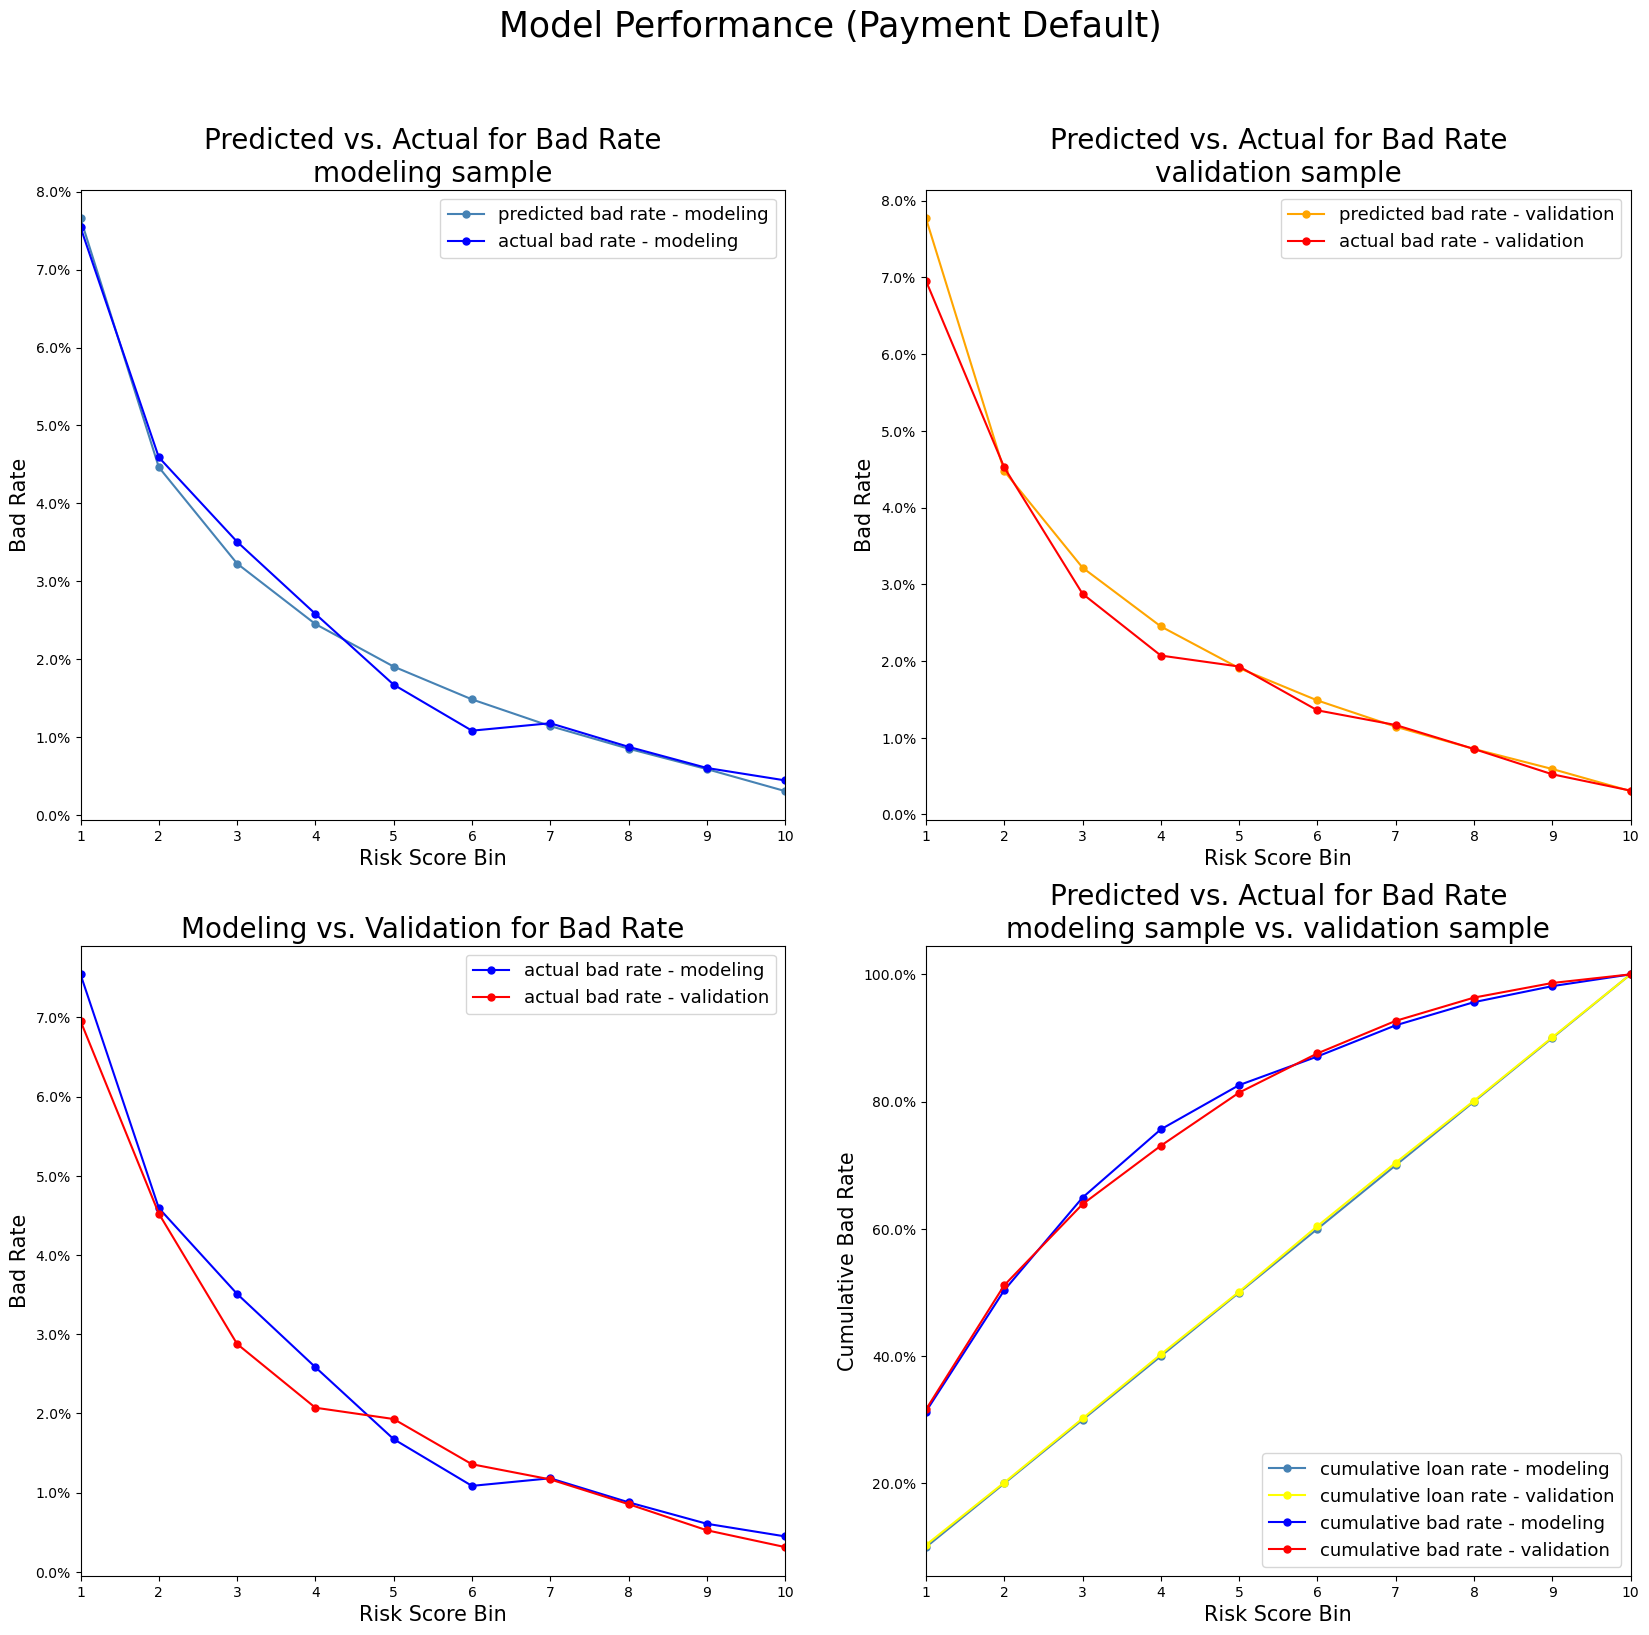

In [68]:
# Here we draw the gains/lifts chart.
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter

# python array ends at 10=11-1
ticks=np.arange(1, 11, step=1)

fig, axs=plt.subplots(2, 2, figsize=(20, 18))

# specify the font size
titlesize=20
labelsize=15
legendsize=13

# specify the title 
fig.suptitle("Model Performance (Payment Default)", fontsize=25)

####################################################################################################################################
# subgraph one: 
####################################################################################################################################
axs[0,0].set_title('Predicted vs. Actual for Bad Rate\nmodeling sample', fontsize=titlesize)
# specify the ticks
axs[0,0].set_xticks(ticks)
# ten deciles
axs[0,0].set_xlim(1, 10)
# plot the predicted risk score on the training set
axs[0,0].plot(df_agg['risk_score_cut'], df_agg['predicted_mod'], color='steelblue', marker='.', markersize=10, label='predicted bad rate - modeling')
# plot the actual 'bad' loan ratio of the trainig set
axs[0,0].plot(df_agg['risk_score_cut'], df_agg['actual_bad_mod'], color='blue', marker='.', markersize=10, label='actual bad rate - modeling')
axs[0,0].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[0,0].set_ylabel('Bad Rate', fontsize=labelsize)
# format the y-axis to 1%
axs[0,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
axs[0,0].legend(loc='upper right', fontsize=legendsize)

####################################################################################################################################
# subgraph two: 
####################################################################################################################################
axs[0,1].set_title('Predicted vs. Actual for Bad Rate\nvalidation sample', fontsize=titlesize)
axs[0,1].set_xticks(ticks)
axs[0,1].set_xlim(1, 10)
axs[0,1].plot(df_agg['risk_score_cut'], df_agg['predicted_val'], color='orange', marker='.', markersize=10, label='predicted bad rate - validation')
axs[0,1].plot(df_agg['risk_score_cut'], df_agg['actual_bad_val'], color='red', marker='.', markersize=10, label='actual bad rate - validation')
axs[0,1].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[0,1].set_ylabel('Bad Rate', fontsize=labelsize)
axs[0,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
axs[0,1].legend(loc='upper right', fontsize=legendsize)

####################################################################################################################################
# subgraph three: 
####################################################################################################################################
axs[1,0].set_title('Modeling vs. Validation for Bad Rate', fontsize=titlesize)
axs[1,0].set_xticks(ticks)
axs[1,0].set_xlim(1, 10)
axs[1,0].plot(df_agg['risk_score_cut'], df_agg['actual_bad_mod'], color='blue', marker='.', markersize=10, label='actual bad rate - modeling')
axs[1,0].plot(df_agg['risk_score_cut'], df_agg['actual_bad_val'], color='red', marker='.', markersize=10, label='actual bad rate - validation')
axs[1,0].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[1,0].set_ylabel('Bad Rate', fontsize=labelsize)
axs[1,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
axs[1,0].legend(loc='upper right', fontsize=legendsize)

####################################################################################################################################
# subgraph four: 
####################################################################################################################################
axs[1,1].set_title('Predicted vs. Actual for Bad Rate\nmodeling sample vs. validation sample', fontsize=titlesize)
axs[1,1].set_xticks(ticks)
axs[1,1].set_xlim(1, 10)
# Plot the cumulative distribution of total loans. Since we divide the sample into 10 even bins, these two line should
# be a straight line.
axs[1,1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_all_mod'], color='steelblue', marker='.', markersize=10, label='cumulative loan rate - modeling')
axs[1,1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_all_val'], color='yellow', marker='.', markersize=10, label='cumulative loan rate - validation')
# Plot the distribution of the bad loan rate.
axs[1,1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_bad_mod'], color='blue', marker='.', markersize=10, label='cumulative bad rate - modeling')
axs[1,1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_bad_val'], color='red', marker='.', markersize=10, label='cumulative bad rate - validation')
axs[1,1].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[1,1].set_ylabel('Cumulative Bad Rate', fontsize=labelsize)
axs[1,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
axs[1,1].legend(loc='lower right', fontsize=legendsize)

In [69]:
# calculate KS statistics
df_agg[['risk_score_cut', 'cumu_pct_all_mod', 'cumu_pct_bad_mod',  'cumu_pct_good_mod',
        'cumu_pct_all_val', 'cumu_pct_bad_val',  'cumu_pct_good_val']].head(10)

,risk_score_cut,cumu_pct_all_mod,cumu_pct_bad_mod,cumu_pct_good_mod,cumu_pct_all_val,cumu_pct_bad_val,cumu_pct_good_val
0,1,0.099989,0.313038,0.094729,0.103359,0.316284,0.098408
1,2,0.199994,0.503640,0.192497,0.201452,0.511482,0.194242
2,3,0.299982,0.649239,0.291360,0.302083,0.638831,0.294252
3,4,0.399987,0.756453,0.391187,0.402880,0.730689,0.395257
4,5,0.499976,0.825943,0.491929,0.501305,0.814196,0.494029
5,6,0.599981,0.870946,0.593292,0.604427,0.875783,0.598116
6,7,0.699986,0.919921,0.694556,0.704109,0.926931,0.698927
7,8,0.799974,0.956320,0.796115,0.801371,0.963466,0.797602
8,9,0.899979,0.981469,0.897968,0.900958,0.986430,0.898971
9,10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


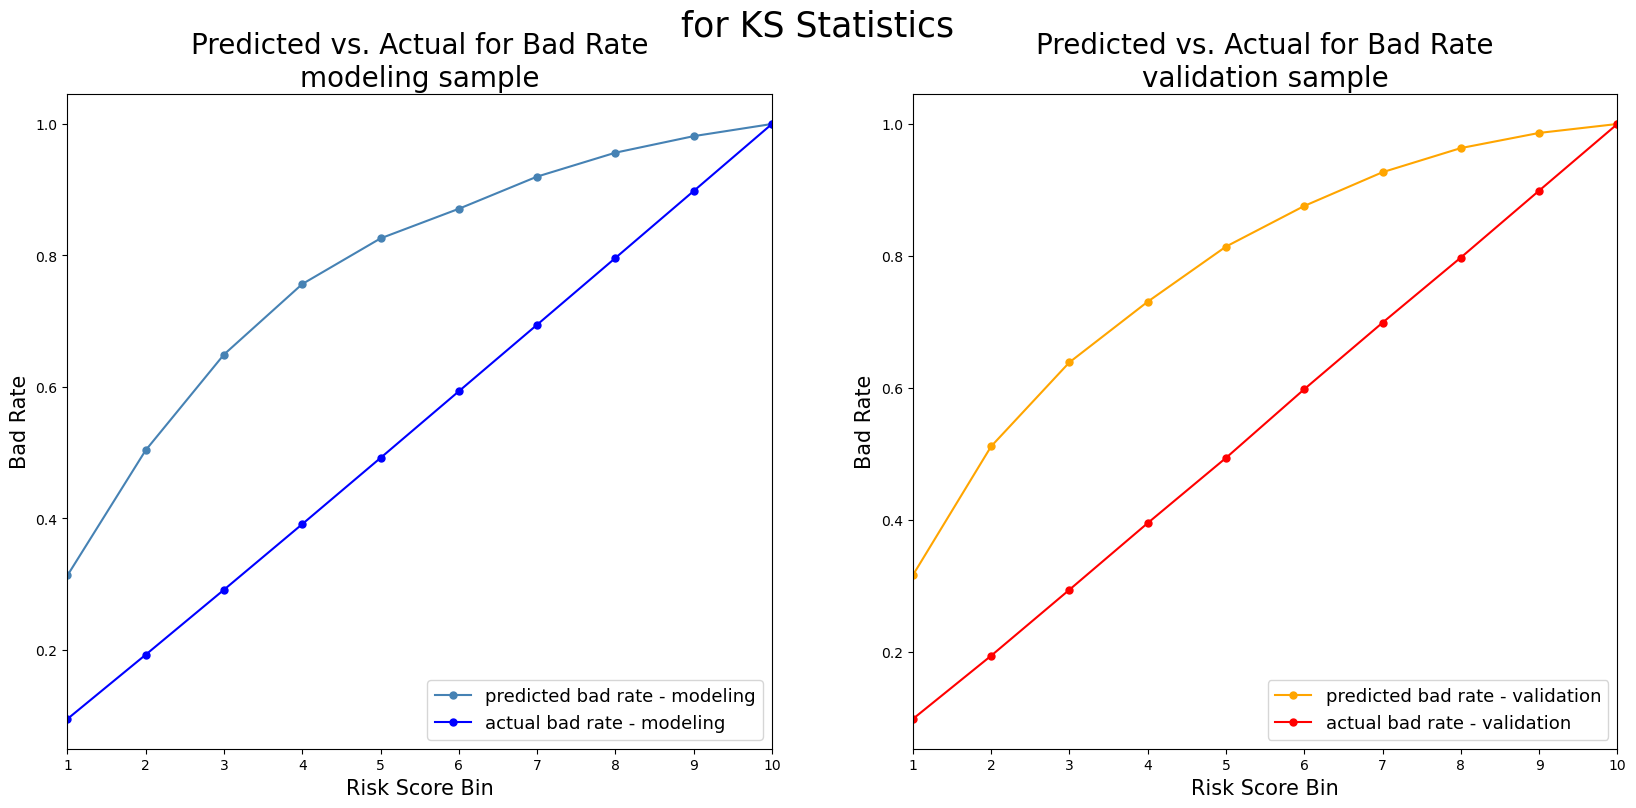

In [71]:
# calculate KS statistics
# python array ends at 10=11-1
ticks=np.arange(1, 11, step=1)

fig, axs=plt.subplots(1, 2, figsize=(20, 8.5))

titlesize=20
labelsize=15
legendsize=13

fig.suptitle("for KS Statistics", fontsize=25)

axs[0].set_title('Predicted vs. Actual for Bad Rate\nmodeling sample', fontsize=titlesize)
axs[0].set_xticks(ticks)
axs[0].set_xlim(1, 10)
axs[0].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_bad_mod'], color='steelblue', marker='.', markersize=10, label='predicted bad rate - modeling')
axs[0].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_good_mod'], color='blue', marker='.', markersize=10, label='actual bad rate - modeling')
axs[0].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[0].set_ylabel('Bad Rate', fontsize=labelsize)
axs[0].legend(loc='lower right', fontsize=legendsize)

axs[1].set_title('Predicted vs. Actual for Bad Rate\nvalidation sample', fontsize=titlesize)
axs[1].set_xticks(ticks)
axs[1].set_xlim(1, 10)
axs[1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_bad_val'], color='orange', marker='.', markersize=10, label='predicted bad rate - validation')
axs[1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_good_val'], color='red', marker='.', markersize=10, label='actual bad rate - validation')
axs[1].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[1].set_ylabel('Bad Rate', fontsize=labelsize)
axs[1].legend(loc='lower right', fontsize=legendsize)

In [72]:
print("KS statistics for the modeling sample: ", max(df_agg['cumu_pct_bad_mod']-df_agg['cumu_pct_good_mod']))
print("KS statistics for the validation sample: ", max(df_agg['cumu_pct_bad_val']-df_agg['cumu_pct_good_val']))

KS statistics for the modeling sample:  0.36526554182831117
KS statistics for the validation sample:  0.3445790285900429


In [78]:
# Compare with the results if we conduct K-S test using the scipy package.
# Training set.
bad_model  = copy.deepcopy(df_mod[df_mod['bad']==1])
good_model = copy.deepcopy(df_mod[df_mod['bad']==0])
sam1_mod   = bad_model['risk_score']
sam2_mod   = good_model['risk_score']
stats.ks_2samp(sam1_mod, sam2_mod)

KstestResult(statistic=0.36983015749203196, pvalue=1.700314183275109e-181)

In [82]:
# Validation set.
bad_vali   = copy.deepcopy(df_val[df_val['bad']==1])
good_vali  = copy.deepcopy(df_val[df_val['bad']==0])
sam1_val   = bad_vali['risk_score']
sam2_val   = good_vali['risk_score']
stats.ks_2samp(sam1_val, sam2_val)

KstestResult(statistic=0.34955731762270537, pvalue=9.78870131231338e-103)

### Part 6: Decline reason
* We want to give two decline reasons for not approving a loan application

In [84]:
# check the model score means 
cscore_mean, dti_mean, oltv_mean, upb_mean=df_mod[['CSCORE_B', 'DTI', 'OLTV', 'ORIG_UPB']].mean()
print(cscore_mean, dti_mean, oltv_mean, upb_mean)

0.6362907427272974 0.6694523281832145 0.7431626725342942 0.3084451695106994


In [90]:
# get the coefficient estimate from the regression
Intercept, CSCORE_B_coeff, DTI_coeff, OLTV_coeff, ORIG_UPB_coeff = model.params
print(CSCORE_B_coeff, DTI_coeff, OLTV_coeff, ORIG_UPB_coeff)

-2.882862356134326 2.265092052279452 2.154697884377886 1.1593101655560305


In [91]:
# calculate the contributing power of each input variable
def contribution(x):
    x['cscore_contribution'] = x['CSCORE_B']*CSCORE_B_coeff*-1    # because sign is negative for CSCORE_B
    x['dti_contribution']    = x['DTI']*DTI_coeff
    x['oltv_contribution']   = x['OLTV']*OLTV_coeff
    x['upb_contribution']    = x['ORIG_UPB']*ORIG_UPB_coeff
    
contribution(df_val)

In [92]:
# rank order contributing factor from highest to lowest for all input variables
# select the top 3 contributors
# First we take out the contribution variables.
x = copy.deepcopy(df_val[['LOAN_ID', 'cscore_contribution', 'dti_contribution', 
                          'oltv_contribution', 'upb_contribution']].set_index('LOAN_ID'))
x

,cscore_contribution,dti_contribution,oltv_contribution,upb_contribution
LOAN_ID,,,,
98836744,1.676083,1.887577,1.580112,0.300834
98836951,0.603390,1.793198,2.106816,0.145281
98837003,0.831337,1.038167,1.747699,0.181968
98837167,1.917439,1.415683,0.574586,0.061634
98837237,2.467194,1.887577,1.867405,0.620745
...,...,...,...,...
99520212,1.676083,2.123524,1.987110,0.540033
99520223,1.756535,2.217903,1.627994,0.425570
99520260,2.507420,1.557251,1.747699,0.713196


In [93]:
# Order the top 3 contributors for each observation.
nlargest=3
order=np.argsort(-x.values, axis=1)[:, :nlargest]
order

array([[1, 0, 2],
       [2, 1, 0],
       [2, 1, 0],
       ...,
       [0, 2, 1],
       [2, 0, 1],
       [0, 2, 1]])

In [94]:
# Look at the data.
df_top_drivers=pd.DataFrame(x.columns[order],
                            columns=['driver{}'.format(i) for i in range(1, nlargest+1)],
                            index=x.index)

print(df_top_drivers.head())

                      driver1              driver2              driver3
LOAN_ID                                                                
98836744     dti_contribution  cscore_contribution    oltv_contribution
98836951    oltv_contribution     dti_contribution  cscore_contribution
98837003    oltv_contribution     dti_contribution  cscore_contribution
98837167  cscore_contribution     dti_contribution    oltv_contribution
98837237  cscore_contribution     dti_contribution    oltv_contribution


/var/folders/wp/k6ync4cd6vl262_wn1b0y6lc0000gn/T/ipykernel_15802/3675680012.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_top_drivers=pd.DataFrame(x.columns[order],


#### Suppose we want to decline 10% of applicants with highest risk, and we are required to give 3 decline reasons.

In [100]:
# Merge the dataset with the top 3 contributors.
df_final = pd.merge(df_val, df_top_drivers, on='LOAN_ID', how='inner')

# applicants in decile 1 are to be declined, since they have the highest risk score.
df_final = copy.deepcopy(df_final[df_final['risk_score_cut']==1].reset_index())

# check their mean risk score
df_final.groupby('risk_score_cut')['risk_score'].mean()

risk_score_cut
1    0.077687
Name: risk_score, dtype: float64

In [108]:
# For missing data, we will fill in 'no data' for variable value. 
# However, note that here due to our data cleaning process before, there should be no missing data.
rawvar_list=['CSCORE_B', 'DTI', 'OLTV', 'ORIG_UPB']

for item in rawvar_list:
    df_final.loc[df_final[item].isnull(), item]='no data'

In [110]:
# assign decline reasons
def assign_reason(reason_code, driver): 
    # construct a column called 'reason_code'. If the 'driver' is 'cscore_contribution', then we resport the original
    # Credit score. If not , then if the 'driver' is 'dti_contribution', we report the 'Debt-to-income ratio '.
    # Otherwise, we report the 'Loan-to-value ratio'.
    df_final[reason_code]=np.where(df_final[driver]=='cscore_contribution', 'Credit score is too low: '+df_final['CSCORE_B_raw'].astype(int).astype(str),
                                   np.where(df_final[driver]=='dti_contribution', 'Debt-to-income ratio is too high: '+df_final['DTI_raw'].astype(int).astype(str),
                                            np.where(df_final[driver]=='oltv_contribution', 'Loan-to-value ratio is too high: '+df_final['OLTV_raw'].astype(int).astype(str), 
                                                     'Loan amount is too high: '+df_final['ORIG_UPB_raw'].astype(int).astype(str))))

# generate reason feature for the top three contributors for each observation
assign_reason('reason_code1', 'driver1')
assign_reason('reason_code2', 'driver2')
assign_reason('reason_code3', 'driver3')

In [111]:
df_final[['LOAN_ID', 
          'driver1', 'reason_code1',
          'driver2', 'reason_code2',
          'driver3', 'reason_code3']]

,LOAN_ID,driver1,reason_code1,driver2,reason_code2,driver3,reason_code3
0,98836951,oltv_contribution,Loan-to-value ratio is too high: 95,dti_contribution,Debt-to-income ratio is too high: 40,cscore_contribution,Credit score is too low: 665
1,98837560,dti_contribution,Debt-to-income ratio is too high: 47,oltv_contribution,Loan-to-value ratio is too high: 90,cscore_contribution,Credit score is too low: 729
2,98837615,oltv_contribution,Loan-to-value ratio is too high: 93,dti_contribution,Debt-to-income ratio is too high: 41,cscore_contribution,Credit score is too low: 688
3,98837855,dti_contribution,Debt-to-income ratio is too high: 46,oltv_contribution,Loan-to-value ratio is too high: 80,cscore_contribution,Credit score is too low: 710
4,98838765,dti_contribution,Debt-to-income ratio is too high: 49,oltv_contribution,Loan-to-value ratio is too high: 65,cscore_contribution,Credit score is too low: 681
...,...,...,...,...,...,...,...
4352,99518977,dti_contribution,Debt-to-income ratio is too high: 48,oltv_contribution,Loan-to-value ratio is too high: 66,cscore_contribution,Credit score is too low: 679
4353,99519109,oltv_contribution,Loan-to-value ratio is too high: 92,dti_contribution,Debt-to-income ratio is too high: 40,cscore_contribution,Credit score is too low: 701
4354,99520113,dti_contribution,Debt-to-income ratio is too high: 44,oltv_contribution,Loan-to-value ratio is too high: 59,cscore_contribution,Credit score is too low: 667
4355,99520184,dti_contribution,Debt-to-income ratio is too high: 47,oltv_contribution,Loan-to-value ratio is too high: 90,cscore_contribution,Credit score is too low: 728


In [112]:
# use a few examples to illustrate
df_example=df_final[df_final['LOAN_ID']==98836951][['LOAN_ID', 'reason_code1', 'reason_code2', 'reason_code3']].reset_index()
df_example.head()

,index,LOAN_ID,reason_code1,reason_code2,reason_code3
0,0,98836951,Loan-to-value ratio is too high: 95,Debt-to-income ratio is too high: 40,Credit score is too low: 665


In [113]:
print("Dear Applicant, \nYour mortgage application (Ref #: {}) has been declined due to the following adverse reasons: \n1) {}\n2) {}\n3) {}".format(df_example['LOAN_ID'][0], 
                                                                                                                  df_example['reason_code1'][0], 
                                                                                                                  df_example['reason_code2'][0], 
                                                                                                                  df_example['reason_code3'][0]))

Dear Applicant, 
Your mortgage application (Ref #: 98836951) has been declined due to the following adverse reasons: 
1) Loan-to-value ratio is too high: 95
2) Debt-to-income ratio is too high: 40
3) Credit score is too low: 665


In [114]:
df_example=df_final[df_final['LOAN_ID']==99520184][['LOAN_ID', 'reason_code1', 'reason_code2', 'reason_code3']].reset_index()
df_example.head()

,index,LOAN_ID,reason_code1,reason_code2,reason_code3
0,4355,99520184,Debt-to-income ratio is too high: 47,Loan-to-value ratio is too high: 90,Credit score is too low: 728


In [115]:
print("Dear Applicant, \nYour mortgage application (Ref #: {}) has been declined due to the following adverse reasons: \n1) {}\n2) {}\n3) {}".format(df_example['LOAN_ID'][0], 
                                                                                                                  df_example['reason_code1'][0], 
                                                                                                                  df_example['reason_code2'][0], 
                                                                                                                  df_example['reason_code3'][0]))

Dear Applicant, 
Your mortgage application (Ref #: 99520184) has been declined due to the following adverse reasons: 
1) Debt-to-income ratio is too high: 47
2) Loan-to-value ratio is too high: 90
3) Credit score is too low: 728


### Part 7: Another logistic regression (very commonly used)
* Use both mean and standard deviation to standardize a variable.
* It helps to reduce multicollinearity. 
* This is closest to data pre-preparation for deep learning. 

#### Part 7.1 - standardize varibles

In [116]:
# Define a function to standardize data. Note that we should use the training data.
def standardize(x, sample):
    x_mean = df_mod[x].mean()
    x_std  = df_mod[x].std()
    x_standardized = (sample[x]-x_mean)/x_std
    return x_standardized

# standardization criteria (min, max, std) should be based on the modeling sample
df_mod['CSCORE_B'] = standardize('CSCORE_B_raw', df_mod)
df_mod['DTI']      = standardize('DTI_raw', df_mod)
df_mod['OLTV']     = standardize('OLTV_raw', df_mod)
df_mod['ORIG_UPB'] = standardize('ORIG_UPB_raw', df_mod)

# apply the same criteria on the validation sample.
# We cannot use the min and max based on the validation sample.
df_val['CSCORE_B'] = standardize('CSCORE_B_raw', df_val)
df_val['DTI']      = standardize('DTI_raw', df_val)
df_val['OLTV']     = standardize('OLTV_raw', df_val)
df_val['ORIG_UPB'] = standardize('ORIG_UPB_raw', df_val)

In [117]:
# check the summary statistics of the training data
df_mod.drop(['LOAN_ID', 'random'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
CSCORE_B,62717.0,1.268887e-16,1.000000,-3.228100,-0.656050,0.217031,0.806951,1.845209
DTI,62717.0,2.809678e-17,1.000000,-3.354837,-0.744777,0.090443,0.821259,1.656479
OLTV,62717.0,3.009075e-16,1.000000,-4.125947,-0.548071,0.130491,0.685679,1.425929
ORIG_UPB,62717.0,-1.450157e-17,1.000000,-1.968599,-0.781001,-0.134689,0.657043,4.413731
bad,62717.0,2.409235e-02,0.153337,0.000000,0.000000,0.000000,0.000000,1.000000
CSCORE_B_raw,62717.0,7.568025e+02,42.378652,620.000000,729.000000,766.000000,791.000000,835.000000
DTI_raw,62717.0,3.413371e+01,9.578324,2.000000,27.000000,35.000000,42.000000,50.000000
OLTV_raw,62717.0,7.388464e+01,16.210735,7.000000,65.000000,76.000000,85.000000,97.000000
ORIG_UPB_raw,62717.0,2.536717e+05,123779.259828,10000.000000,157000.000000,237000.000000,335000.000000,800000.000000
risk_score,62717.0,2.409127e-02,0.022440,0.000394,0.008512,0.016820,0.032156,0.249184


In [118]:
# check the summary statistics of the validation data
df_val.drop(['LOAN_ID', 'random'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
CSCORE_B,42154.0,-0.002352,1.001983,-3.228100,-0.679647,0.217031,0.806951,1.774419
DTI,42154.0,0.007104,1.000130,-3.459239,-0.744777,0.090443,0.821259,1.656479
OLTV,42154.0,0.006682,1.006626,-4.064260,-0.548071,0.130491,0.685679,1.425929
ORIG_UPB,42154.0,0.001634,1.000900,-1.952441,-0.789080,-0.142768,0.665122,4.139048
bad,42154.0,0.022726,0.149031,0.000000,0.000000,0.000000,0.000000,1.000000
CSCORE_B_raw,42154.0,756.702828,42.462700,620.000000,728.000000,766.000000,791.000000,832.000000
DTI_raw,42154.0,34.201760,9.579572,1.000000,27.000000,35.000000,42.000000,50.000000
OLTV_raw,42154.0,73.992954,16.318154,8.000000,65.000000,76.000000,85.000000,97.000000
ORIG_UPB_raw,42154.0,253873.985861,123890.719446,12000.000000,156000.000000,236000.000000,336000.000000,766000.000000
risk_score,42154.0,0.024399,0.023068,0.000400,0.008583,0.016873,0.032069,0.226098


#### Part 7.2 - logistic regresion

In [119]:
# fit the logistic model
model=smf.logit('bad ~ CSCORE_B + DTI + OLTV + ORIG_UPB', data=df_mod).fit()

#view model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.104718
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    bad   No. Observations:                62717
Model:                          Logit   Df Residuals:                    62712
Method:                           MLE   Df Model:                            4
Date:                Sat, 12 Aug 2023   Pseudo R-squ.:                 0.07790
Time:                        23:01:53   Log-Likelihood:                -6567.6
converged:                       True   LL-Null:                       -7122.4
Covariance Type:            nonrobust   LLR p-value:                6.095e-239
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.1021      0.036   -113.905      0.000      -4.173      -4.031
CSCORE_B      -0.5682      0.

In [121]:
# take out the parameters
Intercept, CSCORE_B_para, DTI_para, OLTV_para, ORIG_UPB_para = model.params
print(CSCORE_B_para, DTI_para, OLTV_para, ORIG_UPB_para)

-0.5682410222278246 0.4519955232453576 0.3881026338749954 0.1816437394987144


In [122]:
# make predictions using the model (calculate the logit function value)
def logit(x):
    x['risk_score']=Intercept+CSCORE_B_para*x['CSCORE_B']+DTI_para*x['DTI']+OLTV_para*x['OLTV']+ORIG_UPB_para*x['ORIG_UPB']
    x['risk_score']=1/(1+np.exp(-1*x['risk_score']))

# make prediction using the training and validation set
logit(df_mod)
logit(df_val)

#### Part 7.3 - get the score cut and threshold for defining high-risk bin(s)

In [124]:
# divide the score into 10 evenly distributed bins
df_mod['risk_score_cut']=pd.qcut(df_mod['risk_score'], q=10, retbins=False, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# check the mean risk-score and bad ratio
df_mod.groupby('risk_score_cut')[['risk_score', 'bad']].mean().reset_index()

,risk_score_cut,risk_score,bad
0,0,0.003090,0.004464
1,1,0.005912,0.006059
2,2,0.008532,0.008771
3,3,0.011432,0.011798
4,4,0.014857,0.010842
5,5,0.019065,0.016744
6,6,0.024528,0.025829
7,7,0.032283,0.035082
8,8,0.044645,0.045918
9,9,0.076577,0.075415


In [125]:
# obtain the thresholds for dividing score into 10 bins
# The same thresholds should be applied to both modeling sample and validation sample
# Strictly speaking, you cannot create another score bins based on the validation sample and then apply to the validation sample.
score_threshold = df_mod.groupby('risk_score_cut')['risk_score'].min().reset_index()
score_threshold

,risk_score_cut,risk_score
0,0,0.000394
1,1,0.004626
2,2,0.007218
3,3,0.009916
4,4,0.013044
5,5,0.016821
6,6,0.021547
7,7,0.027864
8,8,0.037334
9,9,0.054000


In [126]:
# Define a function to assign risk scores to each decile.
def score_cut(x):
    
    # Initially Rthe risk score is ranked from lowest to highest.
    # For assigning score bins, we usually start with highest risk bin. 
    threshold0=score_threshold['risk_score'][9]
    threshold1=score_threshold['risk_score'][8]
    threshold2=score_threshold['risk_score'][7]
    threshold3=score_threshold['risk_score'][6]
    threshold4=score_threshold['risk_score'][5]
    threshold5=score_threshold['risk_score'][4]
    threshold6=score_threshold['risk_score'][3]
    threshold7=score_threshold['risk_score'][2]
    threshold8=score_threshold['risk_score'][1]
    
    if x > threshold0:
        return 1
    elif x > threshold1:
        return 2
    elif x > threshold2:
        return 3
    elif x > threshold3:
        return 4
    elif x > threshold4:
        return 5
    elif x > threshold5:
        return 6
    elif x > threshold6:
        return 7
    elif x > threshold7: 
        return 8
    elif x > threshold8:
        return 9
    else:
        return 10

In [127]:
# apply the same score cut to both modeling sample and validation sample
df_mod['risk_score_cut'] = df_mod['risk_score'].apply(score_cut)
df_val['risk_score_cut'] = df_val['risk_score'].apply(score_cut)

#### Part 7.4 - validate the risk score

In [131]:
# check the performance of modeling sample
df_mod.groupby('risk_score_cut').agg(loan_cnt_mod=('CSCORE_B', 'count'),
                                     predicted_mod=('risk_score', 'mean'),
                                     actual_mod=('bad', 'mean'),
                                     bad_cnt_mod=('bad', 'sum')).reset_index()

,risk_score_cut,loan_cnt_mod,predicted_mod,actual_mod,bad_cnt_mod
0,1,6271,0.076580,0.075427,473
1,2,6272,0.044648,0.045918,288
2,3,6271,0.032285,0.035082,220
3,4,6272,0.024529,0.025829,162
4,5,6271,0.019066,0.016744,105
5,6,6272,0.014858,0.010842,68
6,7,6272,0.011433,0.011798,74
7,8,6271,0.008532,0.008771,55
8,9,6272,0.005912,0.006059,38
9,10,6273,0.003091,0.004464,28


In [133]:
# check the performance of validation sample
df_val.groupby('risk_score_cut').agg(loan_cnt_va=('CSCORE_B', 'count'),
                                     predicted_val=('risk_score', 'mean'),
                                     actual_val=('bad', 'mean'),
                                     bad_cnt_val=('bad', 'sum')).reset_index()

,risk_score_cut,loan_cnt_va,predicted_val,actual_val,bad_cnt_val
0,1,4357,0.077690,0.069543,303
1,2,4135,0.044743,0.045224,187
2,3,4242,0.032167,0.028760,122
3,4,4249,0.024509,0.020711,88
4,5,4149,0.019072,0.019282,80
5,6,4347,0.014862,0.013573,59
6,7,4202,0.011440,0.011661,49
7,8,4100,0.008542,0.008537,35
8,9,4198,0.005928,0.005241,22
9,10,4175,0.003050,0.003114,13


In [134]:
# summarize the data for graphing later
df_mod_agg=df_mod.groupby('risk_score_cut').agg(loan_cnt_mod=('CSCORE_B', 'count'),
                                                predicted_mod=('risk_score', 'mean'),
                                                actual_bad_mod=('bad', 'mean'),
                                                actual_bad_cnt_mod=('bad', 'sum'))

# Calculate the good loans and the good-loan ratio.
df_mod_agg['actual_good_cnt_mod']=df_mod_agg['loan_cnt_mod']-df_mod_agg['actual_bad_cnt_mod']
df_mod_agg['loan_pct_mod']=df_mod_agg['loan_cnt_mod']/len(df_mod['CSCORE_B'])

# Valication group.
df_val_agg=df_val.groupby('risk_score_cut').agg(loan_cnt_val=('CSCORE_B', 'count'),
                                                predicted_val=('risk_score', 'mean'),
                                                actual_bad_val=('bad', 'mean'),
                                                actual_bad_cnt_val=('bad', 'sum'))

# Calculate the good loans and the good-loan ratio for the valication group.
df_val_agg['actual_good_cnt_val']=df_val_agg['loan_cnt_val']-df_val_agg['actual_bad_cnt_val']
df_val_agg['loan_pct_val']=df_val_agg['loan_cnt_val']/len(df_val['CSCORE_B'])

# Merge the data together.
df_agg=pd.merge(df_mod_agg, df_val_agg, on='risk_score_cut', how='inner').reset_index()

df_agg

,risk_score_cut,loan_cnt_mod,predicted_mod,actual_bad_mod,actual_bad_cnt_mod,actual_good_cnt_mod,loan_pct_mod,loan_cnt_val,predicted_val,actual_bad_val,actual_bad_cnt_val,actual_good_cnt_val,loan_pct_val
0,1,6271,0.076580,0.075427,473,5798,0.099989,4357,0.077690,0.069543,303,4054,0.103359
1,2,6272,0.044648,0.045918,288,5984,0.100005,4135,0.044743,0.045224,187,3948,0.098093
2,3,6271,0.032285,0.035082,220,6051,0.099989,4242,0.032167,0.028760,122,4120,0.100631
3,4,6272,0.024529,0.025829,162,6110,0.100005,4249,0.024509,0.020711,88,4161,0.100797
4,5,6271,0.019066,0.016744,105,6166,0.099989,4149,0.019072,0.019282,80,4069,0.098425
5,6,6272,0.014858,0.010842,68,6204,0.100005,4347,0.014862,0.013573,59,4288,0.103122
6,7,6272,0.011433,0.011798,74,6198,0.100005,4202,0.011440,0.011661,49,4153,0.099682
7,8,6271,0.008532,0.008771,55,6216,0.099989,4100,0.008542,0.008537,35,4065,0.097262
8,9,6272,0.005912,0.006059,38,6234,0.100005,4198,0.005928,0.005241,22,4176,0.099587
9,10,6273,0.003091,0.004464,28,6245,0.100021,4175,0.003050,0.003114,13,4162,0.099042


In [135]:
# modeling sample
# cumulative sum is for generating lift/gains chart and for calculating KS statistics
df_agg['cumu_cnt_bad_mod']  = df_agg['actual_bad_cnt_mod'].cumsum(axis=0)
df_agg['cumu_cnt_good_mod'] = df_agg['actual_good_cnt_mod'].cumsum(axis=0)
df_agg['cumu_cnt_all_mod']  = df_agg['loan_cnt_mod'].cumsum(axis=0)

df_agg['cumu_pct_bad_mod']  = df_agg['cumu_cnt_bad_mod']/df_agg['actual_bad_cnt_mod'].sum()
df_agg['cumu_pct_good_mod'] = df_agg['cumu_cnt_good_mod']/df_agg['actual_good_cnt_mod'].sum()
df_agg['cumu_pct_all_mod']  = df_agg['cumu_cnt_all_mod']/df_agg['loan_cnt_mod'].sum()


# validation sample
df_agg['cumu_cnt_bad_val']  = df_agg['actual_bad_cnt_val'].cumsum(axis=0)
df_agg['cumu_cnt_good_val'] = df_agg['actual_good_cnt_val'].cumsum(axis=0)
df_agg['cumu_cnt_all_val']  = df_agg['loan_cnt_val'].cumsum(axis=0)

df_agg['cumu_pct_bad_val']  = df_agg['cumu_cnt_bad_val']/df_agg['actual_bad_cnt_val'].sum()
df_agg['cumu_pct_good_val'] = df_agg['cumu_cnt_good_val']/df_agg['actual_good_cnt_val'].sum()
df_agg['cumu_pct_all_val']  = df_agg['cumu_cnt_all_val']/df_agg['loan_cnt_val'].sum()

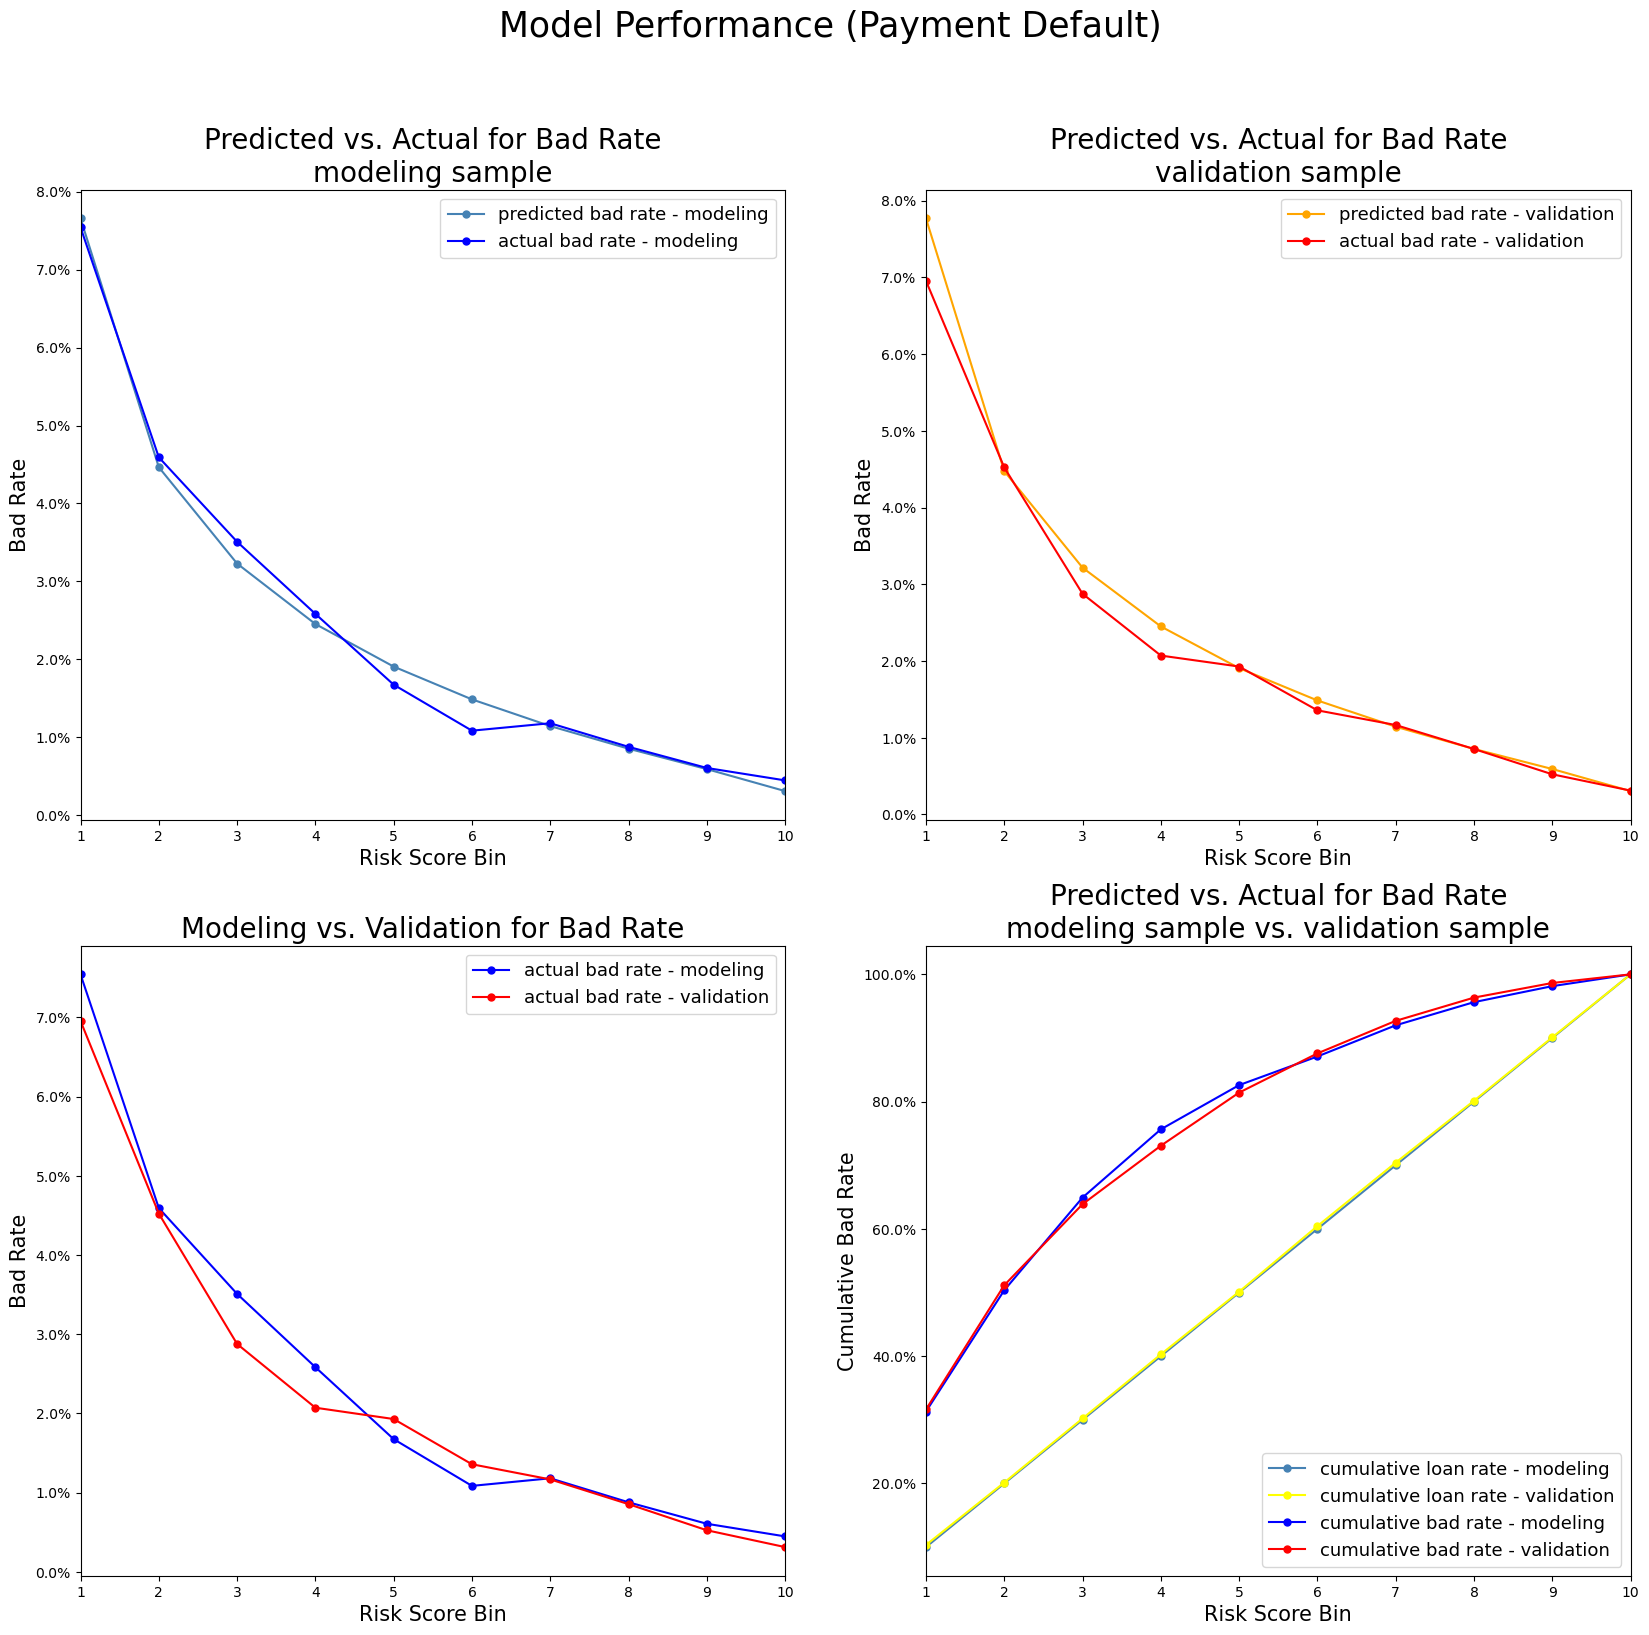

In [136]:
# Here we draw the gains/lifts chart.
# python array ends at 10=11-1
ticks=np.arange(1, 11, step=1)

fig, axs=plt.subplots(2, 2, figsize=(20, 18))

# specify the font size
titlesize=20
labelsize=15
legendsize=13

# specify the title 
fig.suptitle("Model Performance (Payment Default)", fontsize=25)

####################################################################################################################################
# subgraph one: 
####################################################################################################################################
axs[0,0].set_title('Predicted vs. Actual for Bad Rate\nmodeling sample', fontsize=titlesize)
# specify the ticks
axs[0,0].set_xticks(ticks)
# ten deciles
axs[0,0].set_xlim(1, 10)
# plot the predicted risk score on the training set
axs[0,0].plot(df_agg['risk_score_cut'], df_agg['predicted_mod'], color='steelblue', marker='.', markersize=10, label='predicted bad rate - modeling')
# plot the actual 'bad' loan ratio of the trainig set
axs[0,0].plot(df_agg['risk_score_cut'], df_agg['actual_bad_mod'], color='blue', marker='.', markersize=10, label='actual bad rate - modeling')
axs[0,0].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[0,0].set_ylabel('Bad Rate', fontsize=labelsize)
# format the y-axis to 1%
axs[0,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
axs[0,0].legend(loc='upper right', fontsize=legendsize)

####################################################################################################################################
# subgraph two: 
####################################################################################################################################
axs[0,1].set_title('Predicted vs. Actual for Bad Rate\nvalidation sample', fontsize=titlesize)
axs[0,1].set_xticks(ticks)
axs[0,1].set_xlim(1, 10)
axs[0,1].plot(df_agg['risk_score_cut'], df_agg['predicted_val'], color='orange', marker='.', markersize=10, label='predicted bad rate - validation')
axs[0,1].plot(df_agg['risk_score_cut'], df_agg['actual_bad_val'], color='red', marker='.', markersize=10, label='actual bad rate - validation')
axs[0,1].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[0,1].set_ylabel('Bad Rate', fontsize=labelsize)
axs[0,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
axs[0,1].legend(loc='upper right', fontsize=legendsize)

####################################################################################################################################
# subgraph three: 
####################################################################################################################################
axs[1,0].set_title('Modeling vs. Validation for Bad Rate', fontsize=titlesize)
axs[1,0].set_xticks(ticks)
axs[1,0].set_xlim(1, 10)
axs[1,0].plot(df_agg['risk_score_cut'], df_agg['actual_bad_mod'], color='blue', marker='.', markersize=10, label='actual bad rate - modeling')
axs[1,0].plot(df_agg['risk_score_cut'], df_agg['actual_bad_val'], color='red', marker='.', markersize=10, label='actual bad rate - validation')
axs[1,0].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[1,0].set_ylabel('Bad Rate', fontsize=labelsize)
axs[1,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
axs[1,0].legend(loc='upper right', fontsize=legendsize)

####################################################################################################################################
# subgraph four: 
####################################################################################################################################
axs[1,1].set_title('Predicted vs. Actual for Bad Rate\nmodeling sample vs. validation sample', fontsize=titlesize)
axs[1,1].set_xticks(ticks)
axs[1,1].set_xlim(1, 10)
# Plot the cumulative distribution of total loans. Since we divide the sample into 10 even bins, these two line should
# be a straight line.
axs[1,1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_all_mod'], color='steelblue', marker='.', markersize=10, label='cumulative loan rate - modeling')
axs[1,1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_all_val'], color='yellow', marker='.', markersize=10, label='cumulative loan rate - validation')
# Plot the distribution of the bad loan rate.
axs[1,1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_bad_mod'], color='blue', marker='.', markersize=10, label='cumulative bad rate - modeling')
axs[1,1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_bad_val'], color='red', marker='.', markersize=10, label='cumulative bad rate - validation')
axs[1,1].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[1,1].set_ylabel('Cumulative Bad Rate', fontsize=labelsize)
axs[1,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
axs[1,1].legend(loc='lower right', fontsize=legendsize)

In [137]:
# calculate KS statistics
df_agg[['risk_score_cut', 'cumu_pct_all_mod', 'cumu_pct_bad_mod',  'cumu_pct_good_mod',
        'cumu_pct_all_val', 'cumu_pct_bad_val',  'cumu_pct_good_val']].head(10)

,risk_score_cut,cumu_pct_all_mod,cumu_pct_bad_mod,cumu_pct_good_mod,cumu_pct_all_val,cumu_pct_bad_val,cumu_pct_good_val
0,1,0.099989,0.313038,0.094729,0.103359,0.316284,0.098408
1,2,0.199994,0.503640,0.192497,0.201452,0.511482,0.194242
2,3,0.299982,0.649239,0.291360,0.302083,0.638831,0.294252
3,4,0.399987,0.756453,0.391187,0.402880,0.730689,0.395257
4,5,0.499976,0.825943,0.491929,0.501305,0.814196,0.494029
5,6,0.599981,0.870946,0.593292,0.604427,0.875783,0.598116
6,7,0.699986,0.919921,0.694556,0.704109,0.926931,0.698927
7,8,0.799974,0.956320,0.796115,0.801371,0.963466,0.797602
8,9,0.899979,0.981469,0.897968,0.900958,0.986430,0.898971
9,10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


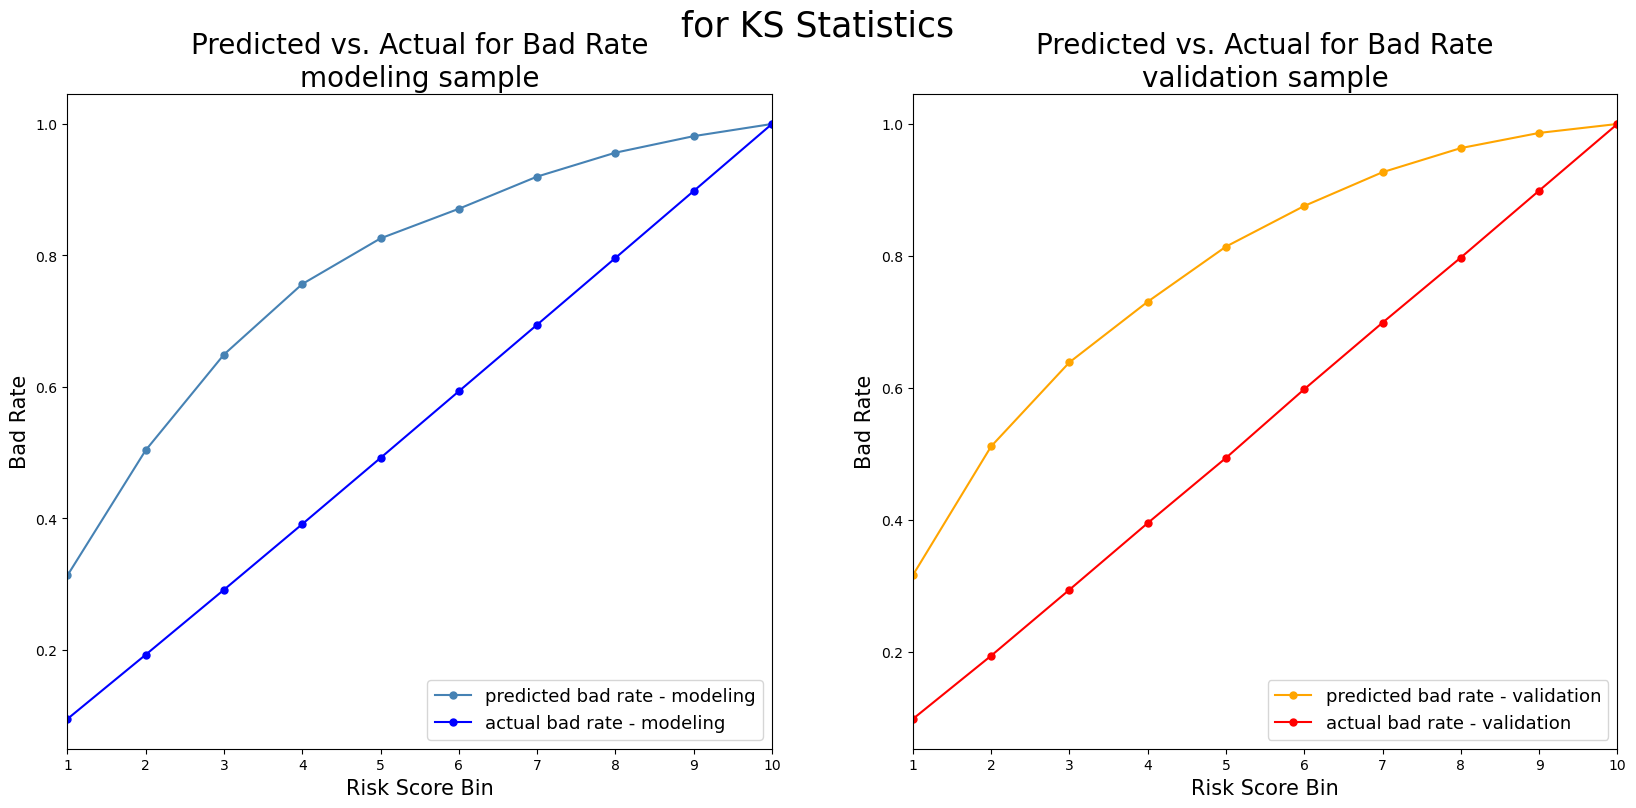

In [138]:
# calculate KS statistics
# python array ends at 10=11-1
ticks=np.arange(1, 11, step=1)

fig, axs=plt.subplots(1, 2, figsize=(20, 8.5))

titlesize=20
labelsize=15
legendsize=13

fig.suptitle("for KS Statistics", fontsize=25)

axs[0].set_title('Predicted vs. Actual for Bad Rate\nmodeling sample', fontsize=titlesize)
axs[0].set_xticks(ticks)
axs[0].set_xlim(1, 10)
axs[0].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_bad_mod'], color='steelblue', marker='.', markersize=10, label='predicted bad rate - modeling')
axs[0].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_good_mod'], color='blue', marker='.', markersize=10, label='actual bad rate - modeling')
axs[0].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[0].set_ylabel('Bad Rate', fontsize=labelsize)
axs[0].legend(loc='lower right', fontsize=legendsize)

axs[1].set_title('Predicted vs. Actual for Bad Rate\nvalidation sample', fontsize=titlesize)
axs[1].set_xticks(ticks)
axs[1].set_xlim(1, 10)
axs[1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_bad_val'], color='orange', marker='.', markersize=10, label='predicted bad rate - validation')
axs[1].plot(df_agg['risk_score_cut'], df_agg['cumu_pct_good_val'], color='red', marker='.', markersize=10, label='actual bad rate - validation')
axs[1].set_xlabel('Risk Score Bin', fontsize=labelsize)
axs[1].set_ylabel('Bad Rate', fontsize=labelsize)
axs[1].legend(loc='lower right', fontsize=legendsize)

#### Part 7.5 - derive contributing factors for decline

In [141]:
# get the coefficient estimate from the regression
Intercept, CSCORE_B_coeff, DTI_coeff, OLTV_coeff, ORIG_UPB_coeff = model.params
print(Intercept, CSCORE_B_coeff, DTI_coeff, OLTV_coeff, ORIG_UPB_coeff)

-4.102060429831882 -0.5682410222278246 0.4519955232453576 0.3881026338749954 0.1816437394987144


In [142]:
# Define a function to calculate the contribution.
def contribution(x):
    x['cscore_contribution'] = x['CSCORE_B']*CSCORE_B_coeff*(-1)    # because sign is negative for CSCORE_B
    x['dti_contribution']    = x['DTI']*DTI_coeff
    x['oltv_contribution']   = x['OLTV']*OLTV_coeff
    x['upb_contribution']    = x['ORIG_UPB']*ORIG_UPB_coeff
    
contribution(df_val)

In [143]:
#  rank order contributing factor from highest to lowest for all input variables
# select the top 3 contributors
x=df_val[['LOAN_ID', 'cscore_contribution', 'dti_contribution', 'oltv_contribution', 'upb_contribution']].set_index('LOAN_ID')

# Rank the contributions.
nlargest=3
order=np.argsort(-x.values, axis=1)[:, :nlargest]

df_top_drivers=pd.DataFrame(x.columns[order],
                            columns=['driver{}'.format(i) for i in range(1, nlargest+1)],
                            index=x.index)

print(df_top_drivers.head())

                      driver1            driver2            driver3
LOAN_ID                                                            
98836744     dti_contribution  oltv_contribution   upb_contribution
98836951    oltv_contribution   dti_contribution   upb_contribution
98837003    oltv_contribution   upb_contribution   dti_contribution
98837167  cscore_contribution   dti_contribution   upb_contribution
98837237  cscore_contribution   dti_contribution  oltv_contribution


/var/folders/wp/k6ync4cd6vl262_wn1b0y6lc0000gn/T/ipykernel_15802/2873836034.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_top_drivers=pd.DataFrame(x.columns[order],


In [144]:
# Merge the loan information with the contributor information.
df_final=pd.merge(df_val, df_top_drivers, on='LOAN_ID', how='inner')

# applicants in decile 1 are to be declined
df_final=df_final[df_final['risk_score_cut']==1].reset_index()

In [145]:
# For missing data, we will fill in 'no data' for variable value. 
rawvar_list=['CSCORE_B', 'DTI', 'OLTV', 'ORIG_UPB']

for item in rawvar_list:
    if np.sum(df_final[item].isnull())==0:
        print('There is no data missing in column:{0}'.format(item))
    else:
        df_final.loc[df_final[item].isnull(), item]='no data'

There is no data missing in column:CSCORE_B
There is no data missing in column:DTI
There is no data missing in column:OLTV
There is no data missing in column:ORIG_UPB


In [146]:
# assign decline reasons
def assign_reason(reason_code, driver): 
    df_final[reason_code]=np.where(df_final[driver]=='cscore_contribution', 'Credit score is too low: '+df_final['CSCORE_B_raw'].astype(int).astype(str),
                                   np.where(df_final[driver]=='dti_contribution', 'Debt-to-income ratio is too high: '+df_final['DTI_raw'].astype(int).astype(str),
                                            np.where(df_final[driver]=='oltv_contribution', 'Loan-to-value ratio is too high: '+df_final['OLTV_raw'].astype(int).astype(str), 
                                                     'Loan amount is too high: '+df_final['ORIG_UPB_raw'].astype(int).astype(str))))


assign_reason('reason_code1', 'driver1')
assign_reason('reason_code2', 'driver2')
assign_reason('reason_code3', 'driver3')

In [147]:
df_final[['LOAN_ID', 
          'driver1', 'reason_code1',
          'driver2', 'reason_code2',
          'driver3', 'reason_code3']]

,LOAN_ID,driver1,reason_code1,driver2,reason_code2,driver3,reason_code3
0,98836951,oltv_contribution,Loan-to-value ratio is too high: 95,dti_contribution,Debt-to-income ratio is too high: 40,upb_contribution,Loan amount is too high: 109000
1,98837560,dti_contribution,Debt-to-income ratio is too high: 47,oltv_contribution,Loan-to-value ratio is too high: 90,upb_contribution,Loan amount is too high: 335000
2,98837615,oltv_contribution,Loan-to-value ratio is too high: 93,upb_contribution,Loan amount is too high: 484000,dti_contribution,Debt-to-income ratio is too high: 41
3,98837855,dti_contribution,Debt-to-income ratio is too high: 46,oltv_contribution,Loan-to-value ratio is too high: 80,upb_contribution,Loan amount is too high: 215000
4,98838765,dti_contribution,Debt-to-income ratio is too high: 49,upb_contribution,Loan amount is too high: 165000,oltv_contribution,Loan-to-value ratio is too high: 65
...,...,...,...,...,...,...,...
4352,99518977,dti_contribution,Debt-to-income ratio is too high: 48,upb_contribution,Loan amount is too high: 410000,oltv_contribution,Loan-to-value ratio is too high: 66
4353,99519109,upb_contribution,Loan amount is too high: 572000,oltv_contribution,Loan-to-value ratio is too high: 92,dti_contribution,Debt-to-income ratio is too high: 40
4354,99520113,dti_contribution,Debt-to-income ratio is too high: 44,upb_contribution,Loan amount is too high: 250000,oltv_contribution,Loan-to-value ratio is too high: 59
4355,99520184,dti_contribution,Debt-to-income ratio is too high: 47,oltv_contribution,Loan-to-value ratio is too high: 90,upb_contribution,Loan amount is too high: 428000


In [148]:
# check data
df_example=df_final[df_final['LOAN_ID']==98836951][['LOAN_ID', 'reason_code1', 'reason_code2', 'reason_code3']].reset_index()
df_example.head()

,index,LOAN_ID,reason_code1,reason_code2,reason_code3
0,0,98836951,Loan-to-value ratio is too high: 95,Debt-to-income ratio is too high: 40,Loan amount is too high: 109000


In [149]:
print("Dear Applicant, \nYour mortgage application (Ref #: {}) has been declined due to the following adverse reasons: \n1) {}\n2) {}\n3) {}".format(df_example['LOAN_ID'][0], 
                                                                                                                  df_example['reason_code1'][0], 
                                                                                                                  df_example['reason_code2'][0], 
                                                                                                                  df_example['reason_code3'][0]))

Dear Applicant, 
Your mortgage application (Ref #: 98836951) has been declined due to the following adverse reasons: 
1) Loan-to-value ratio is too high: 95
2) Debt-to-income ratio is too high: 40
3) Loan amount is too high: 109000
